# Milestone 1 - Chicago, U.S. bikesharing

`Source`: 
https://data.cityofchicago.org/Transportation/Divvy-Trips/fg6s-gzvg/about_data 

`Mobility domain`:
https://data.cityofchicago.org/

`Github repository`:
https://github.com/kbui-03/ChicagoBikeProject


# Target feature of the model: `trip duration` 

By predicting the duration of each trip, we can:
+ Optimise the charging times of electric bikes
+ Present customers with a cost estimate
+ Reduce bike shortages in rush hour
+ and others benefits. 


# Data preparation

Since the dataset given has a total of roughly **21 million rows**, we need to reduce the size of the data before downloading. In order to do that, we used the provided query function to filter the rows: 

`TRIP_ID` is greater than or equal to 22,000,000 AND

`TRIP_ID` is less than or equal to 22,200,000

This left us with about roughly 170.000 unique bike rides to work with, in the time frame of March 2019

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

bike_set = pd.read_csv("Divvy_Trips_Chicago.csv", sep=",")
bike_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169540 entries, 0 to 169539
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TRIP ID            169540 non-null  int64  
 1   START TIME         169540 non-null  object 
 2   STOP TIME          169540 non-null  object 
 3   BIKE ID            169540 non-null  int64  
 4   TRIP DURATION      169540 non-null  int64  
 5   FROM STATION ID    169540 non-null  int64  
 6   FROM STATION NAME  169540 non-null  object 
 7   TO STATION ID      169540 non-null  int64  
 8   TO STATION NAME    169540 non-null  object 
 9   USER TYPE          169540 non-null  object 
 10  GENDER             156307 non-null  object 
 11  BIRTH YEAR         157020 non-null  float64
 12  FROM LATITUDE      169536 non-null  float64
 13  FROM LONGITUDE     169536 non-null  float64
 14  FROM LOCATION      169536 non-null  object 
 15  TO LATITUDE        169530 non-null  float64
 16  TO

# Cleaning the dataset
**Row-wise deletion**

We can observe that there are rows missing `TO LATITUDE`, `TO LONGITUDE`, `TO LOCATION`, `FROM LATITUDE`, `FROM LONGITUDE` and `FROM LOCATION`. These few rows (four to ten rows) can be deleted without a significant impact on the general dataset.

A larger portion of missing values can be seen for the columns `GENDER` and `BIRTH YEAR`. Here, a larger amount of rows, roughly 12,000 to 13,000 rows, are missing. One possible solution for dealing with the missing values is by **imputation**. In this case, it has been suggested to analyze the ratio of male to female bike riders and distribute the rows with missing genders accordingly. But due to the size of missing values we, as a group, have decided to delete them instead, in order to keep the integrity of the dataset as well as the correlation to other features. 

Despite the deletion of those rows, the data still contains sufficient observations with over 100,000 rows which fulfills the given minimum observation requirement.


In [19]:
#deletion of rows with null values
bike_clean_1 = bike_set.dropna()
bike_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156296 entries, 0 to 169539
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   TRIP ID            156296 non-null  int64  
 1   START TIME         156296 non-null  object 
 2   STOP TIME          156296 non-null  object 
 3   BIKE ID            156296 non-null  int64  
 4   TRIP DURATION      156296 non-null  int64  
 5   FROM STATION ID    156296 non-null  int64  
 6   FROM STATION NAME  156296 non-null  object 
 7   TO STATION ID      156296 non-null  int64  
 8   TO STATION NAME    156296 non-null  object 
 9   USER TYPE          156296 non-null  object 
 10  GENDER             156296 non-null  object 
 11  BIRTH YEAR         156296 non-null  float64
 12  FROM LATITUDE      156296 non-null  float64
 13  FROM LONGITUDE     156296 non-null  float64
 14  FROM LOCATION      156296 non-null  object 
 15  TO LATITUDE        156296 non-null  float64
 16  TO LONG

# Feature Selection (column-wise deletion)

**Correlation criteria**: 

- One can observe that `FROM LONGITUDE` and `FROM LATITUDE` are highly correlated to `FROM LOCATION`, which results in redundant information. This also applies to the features 'TO LONGITUDE', 'TO LATITUDE' and 'TO LOCATION'.
- Also, `FROM STATION ID` and `FROM STATION NAME` as well as `TO STATION ID` and `TO STATION NAME` are highly correlated. Therefore, only one feature of each category is needed.
- `START TIME` in combination with `STOP TIME` provides the similar information value as `TRIP DURATION`. One can extract the duration with these features. Since trip duration is the core of our model and the start time provides further information value, the stop time will be removed. 

---

- The `TRIP ID` does not offer much explanatory power and does not contribute to the predictability of the target feature 'TRIP DURATION'. This feature is relevant for uniquely identifying rows while analyzing and processing the data, but not for training the model itself. Hence, this feature will be removed for the cleaned dataset. 
- `TO STATION ID` and `TO STATION NAME` will also be removed from the cleaned dataset since the destination of the trip is not given at the start but rather up to the user. The feature therefore has no use in predicting trip durations. This reasoning also applies to `TO LATITUDE`, `TO LONGITUDE` and `TO LOCATION`. 


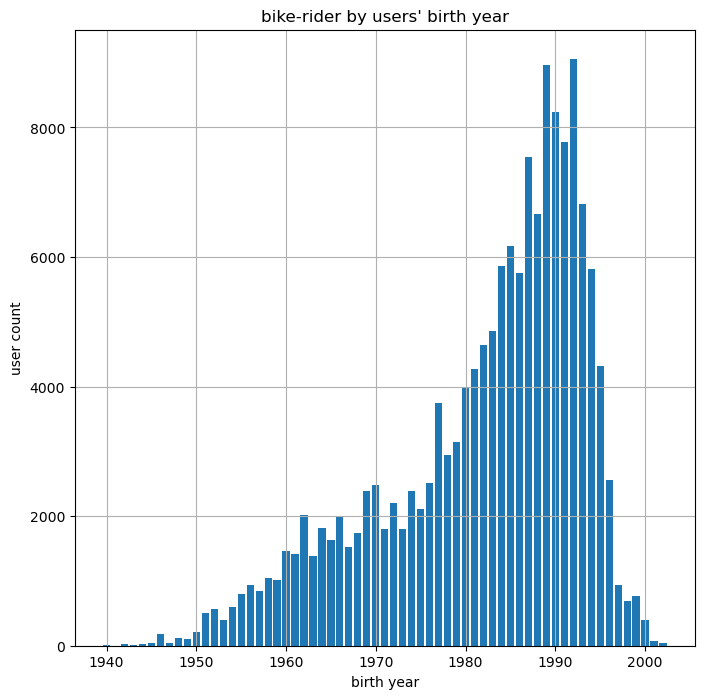

In [51]:
#distribution of birth year
birth_year_counter = bike_clean_1["BIRTH YEAR"].astype(int).value_counts().sort_index()

plt.figure(figsize = (8,8))
plt.bar(birth_year_counter.index, birth_year_counter.values)

plt.xlabel("birth year")
plt.ylabel("user count")
plt.title("bike-rider by users' birth year")
plt.grid()
plt.show()

---
Anomalies in `birth year`   
As one can observe, there are a few outliers in the year 1900 and 1920. It is highly unlikey that a user is older than 105 years and furthermore, the likelihood of a user of that age to ride a bike is even smaller. That is the reason, why these anomalies will be disregarded 

In [ ]:
# remove anomalies in bike data, all rows with birth year before 1940
bike_clean_1 = bike_clean_1[bike_clean_1["BIRTH YEAR"] >= 1940]

In [ ]:
# converting birth year to age
bike_clean_1["AGE"] = (2025-bike_clean_1["BIRTH YEAR"]).astype(int)

,TRIP ID,START TIME,STOP TIME,BIKE ID,TRIP DURATION,FROM STATION ID,FROM STATION NAME,TO STATION ID,TO STATION NAME,USER TYPE,GENDER,FROM LATITUDE,FROM LONGITUDE,FROM LOCATION,TO LATITUDE,TO LONGITUDE,TO LOCATION,AGE
0,22200000,04/03/2019 08:29:54 AM,04/03/2019 08:38:51 AM,5313,537,18,Wacker Dr & Washington St,50,Clark St & Ida B Wells Dr,Subscriber,Male,41.883132,-87.637321,POINT (-87.637321 41.883132),41.875933,-87.630585,POINT (-87.6305845355 41.8759326655),43
1,22199999,04/03/2019 08:29:52 AM,04/03/2019 08:33:36 AM,5884,224,137,Morgan Ave & 14th Pl,55,Halsted St & Roosevelt Rd,Subscriber,Male,41.862378,-87.651062,POINT (-87.651062 41.862378),41.867324,-87.648625,POINT (-87.648625 41.867324),60
2,22199998,04/03/2019 08:29:52 AM,04/03/2019 08:47:57 AM,4048,1085,210,Ashland Ave & Division St,47,State St & Kinzie St,Subscriber,Male,41.903450,-87.667747,POINT (-87.667747 41.90345),41.889187,-87.627754,POINT (-87.627754 41.889187),38
3,22199997,04/03/2019 08:29:50 AM,04/03/2019 08:34:59 AM,2638,309,96,Desplaines St & Randolph St,192,Canal St & Adams St,Subscriber,Male,41.884616,-87.644571,POINT (-87.6445705849 41.88461618962),41.879255,-87.639904,POINT (-87.639904 41.879255),37
4,22199996,04/03/2019 08:29:45 AM,04/03/2019 08:38:06 AM,3179,501,77,Clinton St & Madison St,43,Michigan Ave & Washington St,Subscriber,Male,41.882242,-87.641066,POINT (-87.641066 41.882242),41.883893,-87.624649,POINT (-87.6246491409 41.8838927658),47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169535,22000004,03/05/2019 05:18:57 PM,03/05/2019 05:22:51 PM,4667,234,145,Mies van der Rohe Way & Chestnut St,106,State St & Pearson St,Subscriber,Male,41.898587,-87.621915,POINT (-87.6219152258 41.8985866514),41.897448,-87.628722,POINT (-87.628722 41.897448),74
169536,22000003,03/05/2019 05:18:52 PM,03/05/2019 05:25:19 PM,1667,387,638,Clinton St & Jackson Blvd (*),175,Wells St & Polk St,Subscriber,Male,41.878419,-87.640977,POINT (-87.640977 41.878419),41.872596,-87.633502,POINT (-87.633502 41.872596),42
169537,22000002,03/05/2019 05:18:51 PM,03/05/2019 05:28:42 PM,1694,591,110,Dearborn St & Erie St,66,Clinton St & Lake St,Subscriber,Male,41.893992,-87.629318,POINT (-87.629318 41.893992),41.885637,-87.641823,POINT (-87.641823 41.885637),54
169538,22000001,03/05/2019 05:18:42 PM,03/05/2019 05:24:17 PM,1464,335,44,State St & Randolph St,174,Canal St & Madison St,Subscriber,Male,41.884730,-87.627734,POINT (-87.6277335692 41.8847302006),41.882091,-87.639833,POINT (-87.639833 41.882091),46


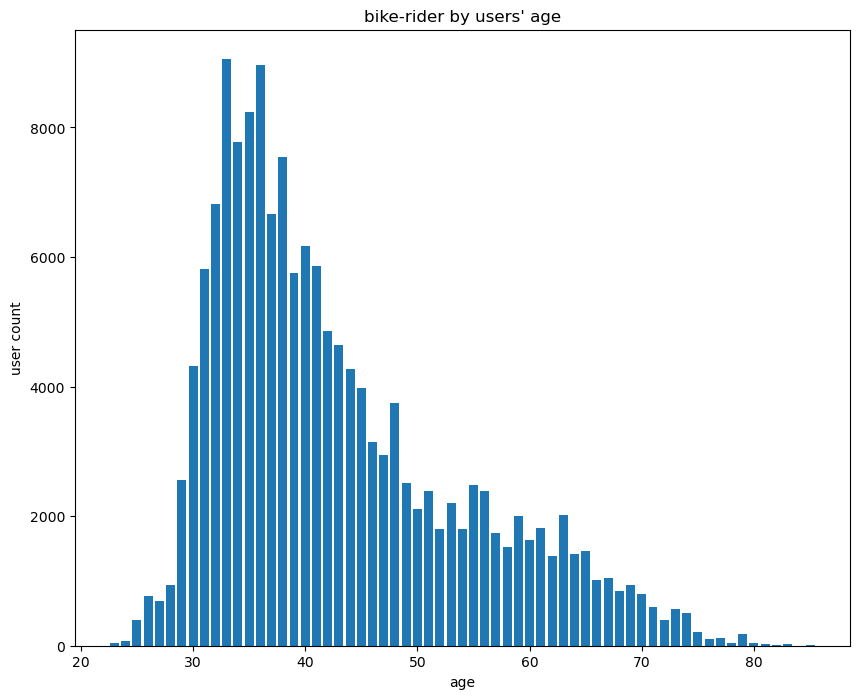

In [84]:
# distribution of age after clean up
age_counter = bike_clean_1["AGE"].astype(int).value_counts().sort_index()

plt.figure(figsize = (10,8))
plt.bar(age_counter.index, age_counter.values)
plt.xlabel("age")
plt.ylabel("user count")
plt.title("bike-rider by users' age")
# plt.grid()
plt.show()

In [ ]:
bike_clean = bike_clean_1.drop(['TRIP ID', 'STOP TIME','FROM STATION NAME','TO STATION ID',
                               'TO STATION NAME','FROM LONGITUDE','FROM LATITUDE','TO LATITUDE',
                               'TO LONGITUDE','TO LOCATION','BIRTH YEAR'], axis=1)
bike_clean.head()

,START TIME,BIKE ID,TRIP DURATION,FROM STATION ID,USER TYPE,GENDER,BIRTH YEAR,FROM LOCATION,AGE
0,04/03/2019 08:29:54 AM,5313,537,18,Subscriber,Male,1982.0,POINT (-87.637321 41.883132),43
1,04/03/2019 08:29:52 AM,5884,224,137,Subscriber,Male,1965.0,POINT (-87.651062 41.862378),60
2,04/03/2019 08:29:52 AM,4048,1085,210,Subscriber,Male,1987.0,POINT (-87.667747 41.90345),38
3,04/03/2019 08:29:50 AM,2638,309,96,Subscriber,Male,1988.0,POINT (-87.6445705849 41.88461618962),37
4,04/03/2019 08:29:45 AM,3179,501,77,Subscriber,Male,1978.0,POINT (-87.641066 41.882242),47


# Data Engineering Ideas

Features to **KEEP**:
+ `START TIME`: Has a high variance and provides much explanatory power
+ `BIKE ID`: Keep for now. While individual bike IDs might not seem predictive, they could capture effects of bike age, maintenance, or type if certain ID ranges correspond to different bike characteristics (though such details are not included in the dataset, further considerations needed)
+ `FROM STATION ID`: Crucial, Trip duration is heavily dependent on its origin.
+ `USER TYPE`: Important. Subscribers and casual customers often exhibit different usage patterns.
+ `GENDER`: Potentially useful demographic information.
+ `BIRTH YEAR:` Useful for deriving rider age.
+ `FROM LATITUDE`, `FROM LONGITUDE`: Maybe. Since Divvy bikes can only be used to and from authorised stations, it is unclear whether specific coordinates are needed

Features to **REMOVE**:
+ `TRIP ID`: This is a unique identifier for each row and generally holds no predictive power for the duration of other trips.
+ `STOP TIME`: Using this directly would be a data leak, as it inherently defines the trip duration when combined with START TIME
+ `TO STATION ID`, `TO LATTITUDE`, `TO LONGTITUDE`: After further research on Divvy services, it seeems the user merely pays for the time frame and not for the distance, since the app won't ask for a destination beforehand (like Uber), therefore the destination cannot be used to predict the duration 
+ `FROM STATION NAME` and `TO STATION NAME`: These are likely redundant if FROM STATION ID and TO STATION ID are clean and used
+ `FROM LOCATION` and `TO LOCATION`: These appear to be string representations of the latitude/longitude point data. 

Features to **ADD**:
+ Temporal Features (from START TIME):
    + HourOfDay
    + DayOfWeek
    + PartOfDay: Categorical feature (e.g., morning, afternoon, evening, night) based on HourOfDay.
+ AGE, calculated from BIRTH YEAR
+ Weather Data:
    + Temperature
    + WindSpeed
    + Precipitation
+ Location-based Features:
    + ZoningDesignation (e.g. residential, business)
    + IncomeLevel
    + Other interesting demographic details (if found)

Todo list:
- Decide which features are important
- Decide python environment
- Decide which new columns to add
- Choose appropriate visualisation of the cleaned dataset
- Seperate dataset into training, validation and test data